# Plots

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## Averages

In [58]:
def plot_averages(path, switch=np.asarray([100, 200]), pop_size=50):
    df = pd.read_json(path).dropna(axis=1, how='all')
    df.columns = pd.MultiIndex.from_tuples(df.columns.map(eval)).rename(['algorithm', 'seed'], level=[0, 1])
    df.index.rename('epoch', inplace=True)
    df = df.stack([0, 1]).groupby(['epoch', 'algorithm']).mean().unstack(1).drop(('estm', 're'), axis=1)
    df.true.re[50:50 + df.true.re.dropna().shape[0]] = df.true.re.dropna()
    df.true.re[:50] = np.nan
    df.columns = [f"{y.upper()}, {'estimated' if x == 'estm' else x}" for x, y in df.columns]
    ax = df.plot()
    ax.legend(labels=['MTNAS, estimates', 'MTNAS, true', 'RE, true'])
    ax.vlines(switch, np.nanmin(df.to_numpy()), np.nanmax(df.to_numpy()),  color='gray', linestyle='--', label='Tier switch')
    if pop_size is not None: ax.vlines(switch + pop_size, np.nanmin(df.to_numpy()), np.nanmax(df.to_numpy()),  color='black', linestyle=':', label='All new evaluations')
    ax.legend()
    plt.show()

### NAS Bench 201

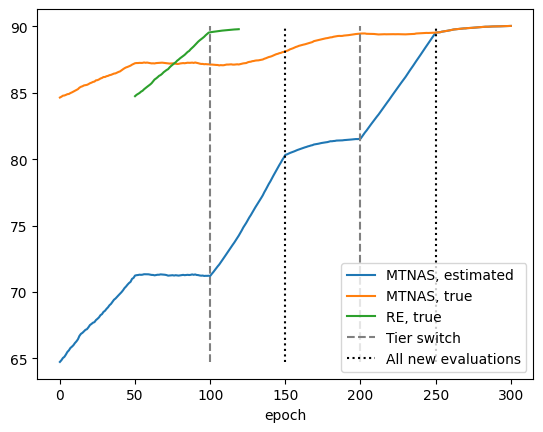

In [75]:
plot_averages('experiments/results/nasbench201/cifar10/tier2sum/averages.json')

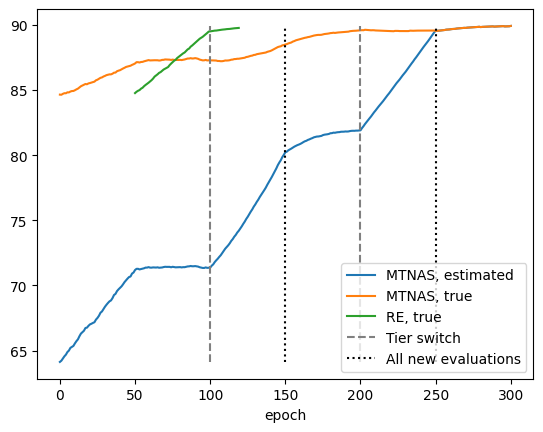

In [59]:
plot_averages('experiments/results/nasbench201/cifar10/default/averages.json')

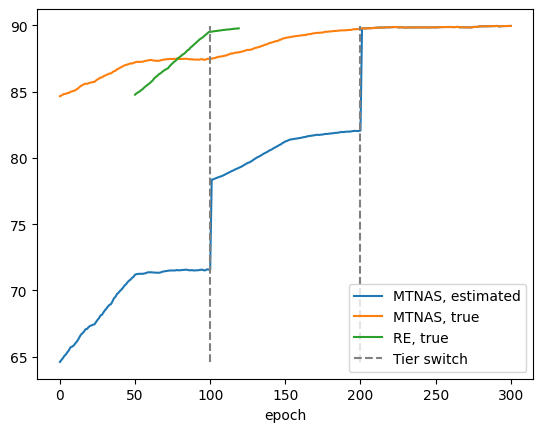

In [61]:
plot_averages('experiments/results/nasbench201/cifar10/reevaluate/averages.json', pop_size=None)

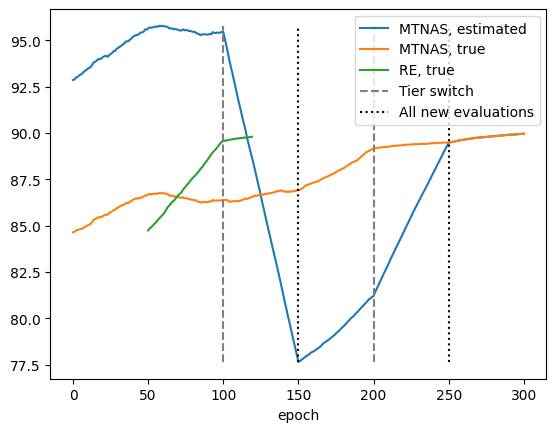

In [62]:
plot_averages('experiments/results/nasbench201/cifar10/tier1high/averages.json')

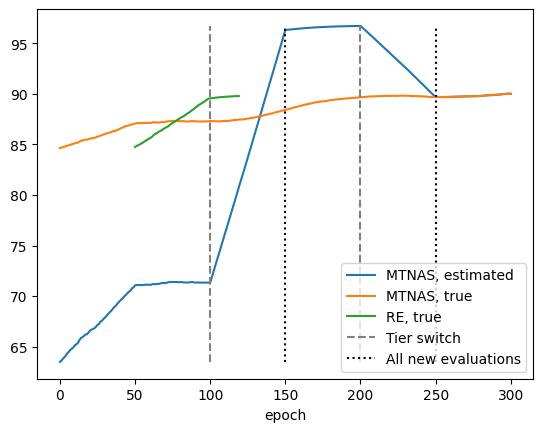

In [63]:
plot_averages('experiments/results/nasbench201/cifar10/tier2high/averages.json')

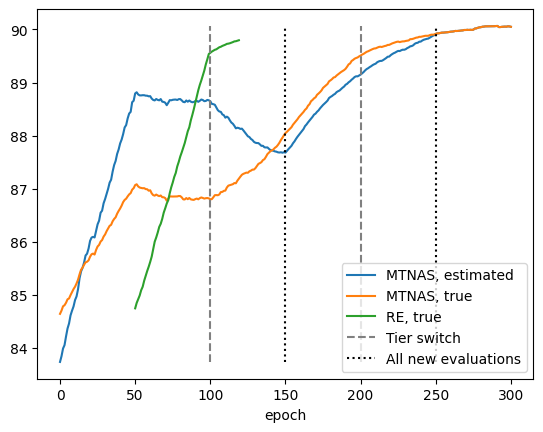

In [111]:
plot_averages('experiments/results/nasbench201/cifar10/equal/averages.json')

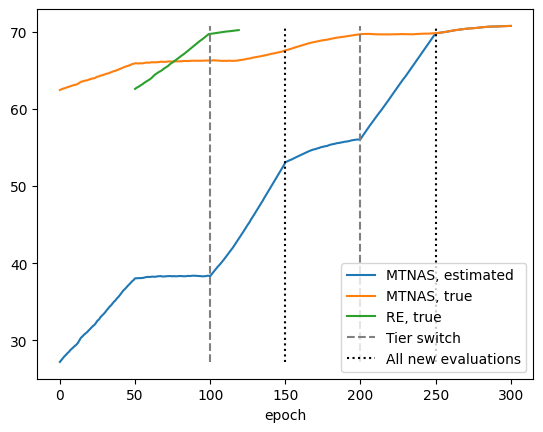

In [109]:
plot_averages('experiments/results/nasbench201/cifar100/default/averages.json')

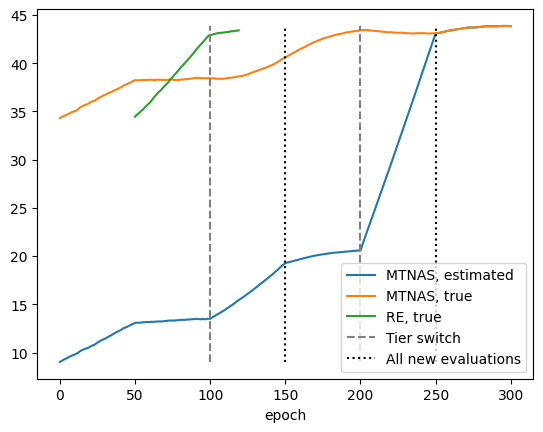

In [110]:
plot_averages('experiments/results/nasbench201/ImageNet16-120/default/averages.json')